## ReLU

sum: -1.86875
quantized sum: -1.87109375
weight exponent: 0.0
Before delay check: 333 neurons.
After delay check: 376 neurons.
2020-09-14 07:44:33.568342 Loihi neuron creation done, now connecting...
2020-09-14 07:44:33.794407 Compiling now...


({'relu:output': array([0.])},
 {'relu:first': array([1073]),
  'relu:output': array([1074, 1075]),
  'relu:second': array([1072]),
  'relu:sync': array([559])})

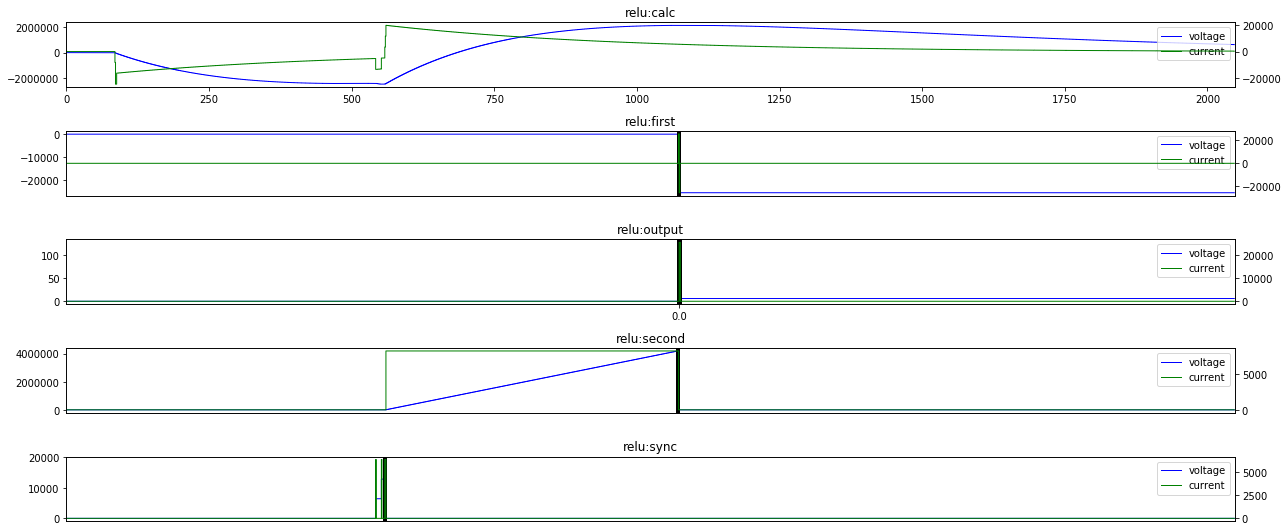

In [12]:
%matplotlib inline
import stick
import numpy as np
t_max = 2**9
run_time = 4*t_max
weight_e = 400
weight_acc = 128

constant_monitor = False

np.random.seed(seed=62)
n_inputs = 4
values =  np.array([0.8872, 0.92325, 0.9215, 0.9112]) # np.random.rand(n_inputs) #
weights =  np.array([1, -1, -1, -1]) # np.random.rand(n_inputs) - 0.5 #
recall_spike_times = [[3] for i in range(n_inputs)] # [[2],[150],[250],[10]]

inputs = []
constants = []
for i, value in enumerate(values):
    constants.append(stick.blocks.ConstantDelay(value, name="const"+str(i)+":", promoted=True, monitor=constant_monitor,
                                                weight_e=weight_e, weight_acc=weight_acc))
    inputs.append(stick.blocks.Splitter(weight_e=weight_e, weight_acc=weight_acc))

relu = stick.blocks.ReLU(list(zip(inputs,weights)), split_output=False, weight_e=weight_e, weight_acc=weight_acc)
relu.blocks += constants
relu.blocks += inputs

for const, inp in zip(constants, inputs):
    const.output_neurons()[0].connect_to(inp.input_neurons()[0], relu.weight_e, relu.t_syn)

quantized_values = (values*t_max).round()/t_max
quantized_weights = (weight_acc*weights).round()/weight_acc

print("sum: {}".format(np.sum(values*weights)))
print("quantized sum: {}".format(np.sum(quantized_values*quantized_weights)))
relu.run_on_loihi(run_time, recall_spike_list=recall_spike_times, t_max=t_max, partition='loihi',
                  probe_selection=["input", "calc", "sync", "first", "second", "const"])

## Max pooling

In [ ]:
%matplotlib inline
import stick
#import numpy as np
recall_spike_times = [[1],[10],[20],]
t_max = 2**8
run_time = 4*t_max

constant_monitor = False

values = [0, 0.152, 0.245]
inputs = []
constants = []
for i, value in enumerate(values):
    constants.append(stick.blocks.ConstantDelay(value, name="const"+str(i)+":", promoted=True, monitor=constant_monitor))
    inputs.append(stick.blocks.Splitter(number=i, monitor=False))

pool = stick.blocks.MaxPooling(inputs, split_input=False, split_output=False, name="", monitor=True)
pool.blocks += constants
pool.blocks += inputs

weight_e, weight_acc, t_syn, t_min, t_neu = pool.get_params_at_once()
for const, inp in zip(constants, inputs):
    const.output_neurons()[0].connect_to(inp.input_neurons()[0], weight_e, t_syn)

pool.run_on_loihi(run_time, recall_spike_list=recall_spike_times, t_max=t_max, partition='loihi', probe_selection=["input", "sync",])